In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import time

import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose_hiive
import mlrose
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve
from sklearn.metrics import accuracy_score

In [61]:
SEED = 903653851 # my GTID
MAX_ATTEMPTS = 200
MAX_ITERATIONS = 200
cur_dir = os.getcwd()

### Hyperparameter Tuning

In [62]:
# Optimization Algorithms
def rhc(opt_problem, max_attempts, max_iters, restarts):
    best_state, best_fitness, fitness_curve = mlrose_hiive.random_hill_climb(opt_problem, 
                                                max_attempts=max_attempts, 
                                                max_iters=max_iters, 
                                                curve=True, 
                                                random_state=SEED,
                                                restarts=restarts)
    return best_state, best_fitness, fitness_curve

def sa(opt_problem, max_attempts, max_iters, geomdecay):
    best_state, best_fitness, fitness_curve = mlrose_hiive.simulated_annealing(
                                                opt_problem, 
                                                max_attempts=max_attempts, 
                                                max_iters=max_iters, 
                                                curve=True, 
                                                random_state=SEED,
                                                schedule=geomdecay)
    return best_state, best_fitness, fitness_curve

def ga(opt_problem, max_attempts, max_iters, pop_size=200, mutation_prob=0.1):
    best_state, best_fitness, fitness_curve = mlrose_hiive.genetic_alg(
                                                opt_problem, 
                                                max_attempts=max_attempts, 
                                                max_iters=max_iters, 
                                                curve=True, 
                                                random_state=SEED,
                                                pop_size=pop_size,
                                                mutation_prob=mutation_prob)
    return best_state, best_fitness, fitness_curve

def mimic(opt_problem, max_attempts, max_iters, pop_size=200, keep_pct=0.2):
    best_state, best_fitness, fitness_curve = mlrose_hiive.mimic(
                                                opt_problem, 
                                                max_attempts=max_attempts, 
                                                max_iters=max_iters,  
                                                curve=True, 
                                                random_state=SEED,
                                                pop_size=pop_size,
                                                keep_pct=keep_pct)
    return best_state, best_fitness, fitness_curve

# Fitness Functions
fitness_functions = {
                "One Max": mlrose_hiive.OneMax(),
                "Flip Flop": mlrose_hiive.FlipFlop(),
                "Four Peaks": mlrose_hiive.FourPeaks()
                }


In [66]:
# Experiments:
# RHC vs restarts (3 graphs, one for each opt_problem) => choose best params combo to get RHC runtime
# SA vs decay schedules => choose best params combo to get SA runtime
# GA vs pop_size and/or mutation_prob => choose best params combo to get GA runtime
# MIMIC vs pop_size and/or keep_pct => choose best params combo to get MIMIC runtime
# time analysis is the final thing => plot all runtimes

RHC - Best parameter value for One Max => restart: 200
RHC - Best parameter value for Flip Flop => restart: 500
RHC - Best parameter value for Four Peaks => restart: 300


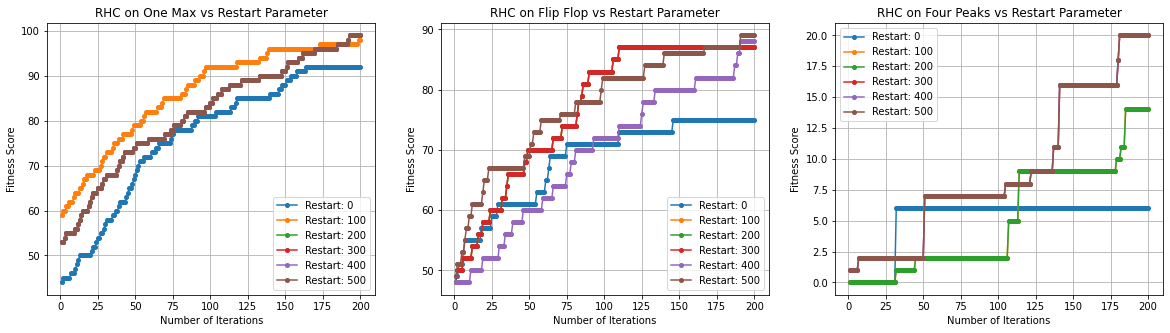

In [ ]:
# Tuning RHC

_, axes = plt.subplots(1, 3, figsize=(20, 5))
ax = 0
for ff_k, ff_v in fitness_functions.items():
    axes[ax].set_title(f"RHC on {ff_k} vs Restart Parameter")

    best_restart_param = None
    best_restart_bf = float("-inf")
    for r in map(int, np.linspace(0, 500, 6)):
        # Define discrete-state optimization problem
        opt_problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=ff_v, maximize=True)
        # Find optimum using RHC
        _, rhc_bf, rhc_fc = rhc(opt_problem, MAX_ATTEMPTS, MAX_ITERATIONS, r)
        if rhc_bf > best_restart_bf:
            # print(f"{ff_k} -> found better (bf) best_fitness: {rhc_bf} at {r}")
            best_restart_param = r
            best_restart_bf = rhc_bf
   
        axes[ax].plot(range(1, MAX_ITERATIONS+1), rhc_fc, "o-", label=f"Restart: {r}", markersize=4)
        axes[ax].set_xlabel("Number of Iterations")
        axes[ax].set_ylabel("Fitness Score")
        axes[ax].legend() # loc="best" by default
    axes[ax].grid()
    ax += 1
    print(f"RHC - Best parameter value for {ff_k} => restart: {best_restart_param}")
plt.savefig(cur_dir + "/plots/HT_RHC_restart")

SA - Best parameter value for One Max => schedule: GeomDecay
SA - Best parameter value for Flip Flop => schedule: ExpDecay
SA - Best parameter value for Four Peaks => schedule: GeomDecay


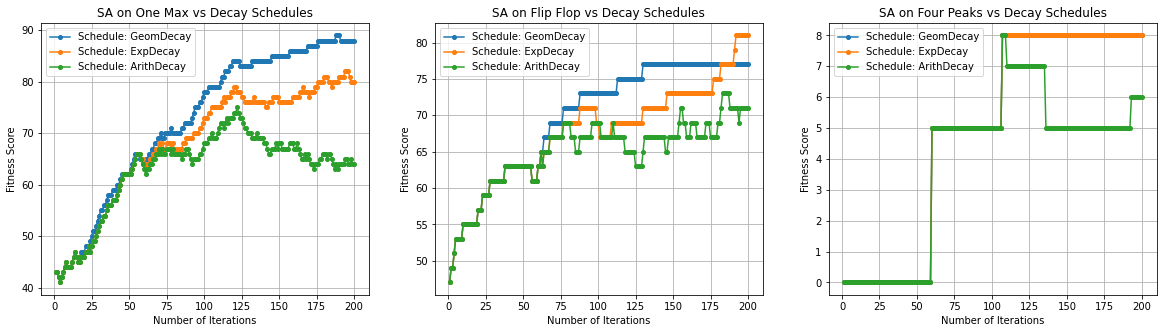

In [48]:
# Tuning SA decay schedules
schedules = [
    ("GeomDecay", mlrose_hiive.GeomDecay()),
    ("ExpDecay", mlrose_hiive.ExpDecay()),
    ("ArithDecay", mlrose_hiive.ArithDecay())
]
_, axes = plt.subplots(1, 3, figsize=(20, 5))
ax = 0
for ff_k, ff_v in fitness_functions.items():
    axes[ax].set_title(f"SA on {ff_k} vs Decay Schedules")
    best_schedule = None
    best_fitness = float("-inf")
    for decay in schedules:
        # Define discrete-state optimization problem
        opt_problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=ff_v, maximize=True)
        # Find optimum using SA
        _, sa_bf, sa_fc = sa(opt_problem, MAX_ATTEMPTS, MAX_ITERATIONS, decay[1])
        if sa_bf > best_fitness:
            # print(f"{ff_k}, found better bf: {sa_bf} with {decay}")
            best_schedule = decay[0]
            best_fitness = sa_bf
        
        axes[ax].plot(range(1, MAX_ITERATIONS+1), sa_fc, "o-", label=f"Schedule: {decay[0]}", markersize=4)
        axes[ax].set_xlabel("Number of Iterations")
        axes[ax].set_ylabel("Fitness Score")
        axes[ax].legend() # loc="best" by default
    axes[ax].grid()
    ax += 1
    print(f"SA - Best parameter value for {ff_k} => schedule: {best_schedule}")
plt.savefig(cur_dir + "/plots/HT_SA_schedule")

In [ ]:
# # Tuning SA selected decay
# sa_hyperparams = [
#    [1, 25, 50, 75, 100],
#    [0.0001, 0.005, 0.01, 0.05],
#    [0.001, 0.01, 0.1, 1]
# ]
# best_param = None
# best_fitness = float("-inf")
# for ff_k, ff_v in fitness_functions.items():
#     for vals in itertools.product(*sa_hyperparams): # gridsearch
#         # Define discrete-state optimization problem
#         opt_problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=ff_v, maximize=True)
#         if "Exp" in str(best_schedule):
#             selected_decay = best_schedule(init_temp=vals[0], exp_const=vals[1], min_temp=vals[2])
#         else:
#             selected_decay = best_schedule(init_temp=vals[0], decay=vals[1], min_temp=vals[2])
#         # Find optimum using SA
#         _, sa_bf, sa_fc = sa(opt_problem, MAX_ATTEMPTS, MAX_ITERATIONS, selected_decay)

#         if sa_bf > best_fitness:
#             # print(f"{ff_k}, found better bf: {sa_bf} at {vals}")
#             best_param = vals
#             best_fitness = sa_bf
    
#     print(f"SA - Best parameter value for {ff_k} => restart: {best_param}")


Four Peaks, found better bf: 5.0 at (1, 0.1, 0.001)
RHC - Best parameter value for Four Peaks => restart: (1, 0.1, 0.001)
Continuous Peaks, found better bf: 11.0 at (1, 0.1, 0.001)
RHC - Best parameter value for Continuous Peaks => restart: (1, 0.1, 0.001)
One Max, found better bf: 81.0 at (1, 0.1, 0.001)
RHC - Best parameter value for One Max => restart: (1, 0.1, 0.001)
336


GA - Best parameter value for One Max => population size: 100
GA - Best parameter value for Flip Flop => population size: 750
GA - Best parameter value for Four Peaks => population size: 250


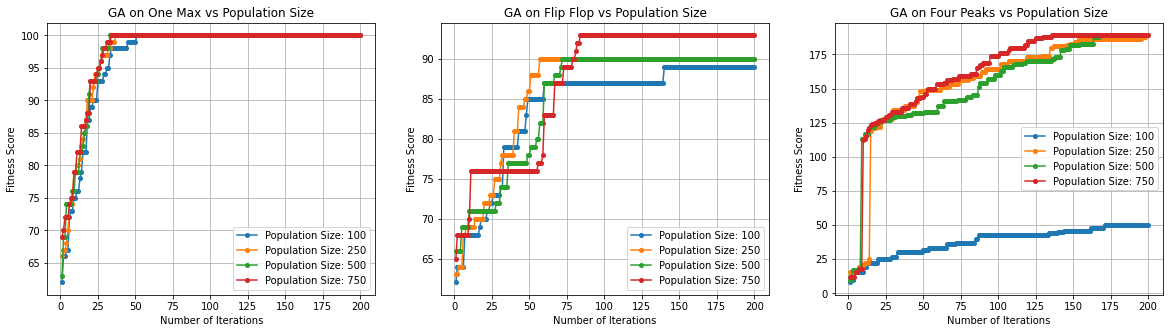

In [45]:
# Tuning GA - pop_size

_, axes = plt.subplots(1, 3, figsize=(20, 5))
ax = 0
for ff_k, ff_v in fitness_functions.items():
    axes[ax].set_title(f"GA on {ff_k} vs Population Size")
    best_param = None
    best_fitness = float("-inf")
    for pop_size in [100, 250, 500, 750]:
        # Define discrete-state optimization problem
        opt_problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=ff_v, maximize=True)
        # Find optimum using GA
        _, ga_bf, ga_fc = ga(opt_problem, MAX_ATTEMPTS, MAX_ITERATIONS, pop_size=pop_size)

        if ga_bf > best_fitness:
            # print(f"{ff_k}, found better bf: {ga_bf} at {pop_size}")
            best_param = pop_size
            best_fitness = ga_bf
        
        axes[ax].plot(range(1, MAX_ITERATIONS+1), ga_fc, "o-", label=f"Population Size: {pop_size}", markersize=4)
        axes[ax].set_xlabel("Number of Iterations")
        axes[ax].set_ylabel("Fitness Score")
        axes[ax].legend() # loc="best" by default
    axes[ax].grid()
    ax += 1
    print(f"GA - Best parameter value for {ff_k} => population size: {best_param}")
plt.savefig(cur_dir + "/plots/HT_GA_pop_size")


GA - Best parameter value for One Max => mutation probability: 0.1
GA - Best parameter value for Flip Flop => mutation probability: 0.1
GA - Best parameter value for Four Peaks => mutation probability: 0.25


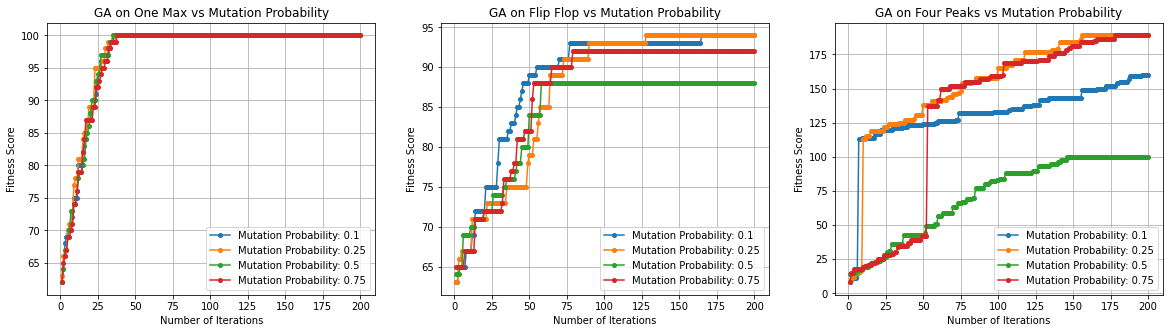

In [50]:
# Tuning GA - mutation_prob

_, axes = plt.subplots(1, 3, figsize=(20, 5))
ax = 0
for ff_k, ff_v in fitness_functions.items():
    axes[ax].set_title(f"GA on {ff_k} vs Mutation Probability")
    best_param = None
    best_fitness = float("-inf")
    for mutation_prob in [.1, .25, .5, .75]:
        # Define discrete-state optimization problem
        opt_problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=ff_v, maximize=True)
        # Find optimum using GA
        ga_bs, ga_bf, ga_fc = ga(opt_problem, MAX_ATTEMPTS, MAX_ITERATIONS, mutation_prob=mutation_prob)

        if ga_bf > best_fitness:
            # print(f"{ff_k}, found better bf: {ga_bf} at {mutation_prob}")
            best_param = mutation_prob
            best_fitness = ga_bf
        
        axes[ax].plot(range(1, MAX_ITERATIONS+1), ga_fc, "o-", label=f"Mutation Probability: {mutation_prob}", markersize=4)
        axes[ax].set_xlabel("Number of Iterations")
        axes[ax].set_ylabel("Fitness Score")
        axes[ax].legend() # loc="best" by default
    axes[ax].grid()
    ax += 1
    print(f"GA - Best parameter value for {ff_k} => mutation probability: {best_param}")
plt.savefig(cur_dir + "/plots/HT_GA_mutation_prob")

MIMIC - Best parameter value for One Max => population size: 400
MIMIC - Best parameter value for Flip Flop => population size: 400
MIMIC - Best parameter value for Four Peaks => population size: 200


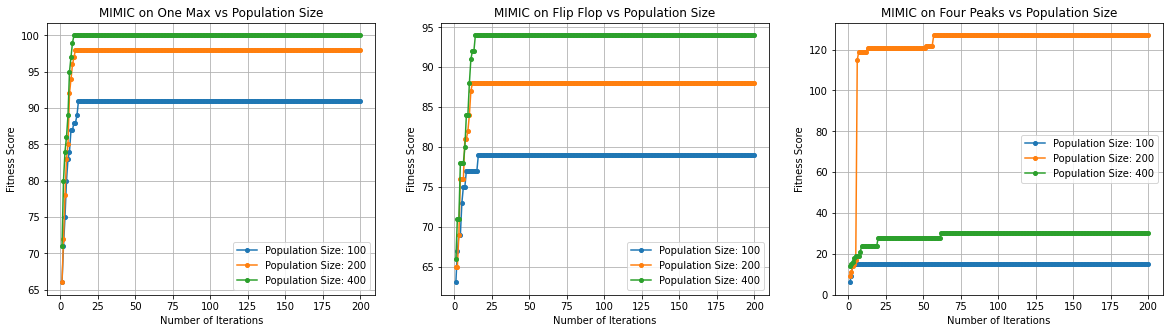

In [42]:
# Tuning MIMIC - Population Size
   
_, axes = plt.subplots(1, 3, figsize=(20, 5))
ax = 0
for ff_k, ff_v in fitness_functions.items():
    axes[ax].set_title(f"MIMIC on {ff_k} vs Population Size")
    best_param = None
    best_fitness = float("-inf")
    for pop_size in [100, 200, 400]:
        # Define discrete-state optimization problem
        opt_problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=ff_v, maximize=True)
        # Find optimum using MIMIC
        _, mimic_bf, mimic_fc = mimic(opt_problem, MAX_ATTEMPTS, MAX_ITERATIONS, pop_size=pop_size)

        if mimic_bf > best_fitness:
            # print(f"{ff_k}, found better bf: {mimic_bf} at {pop_size}")
            best_param = pop_size
            best_fitness = mimic_bf

        axes[ax].plot(range(1, MAX_ITERATIONS+1), mimic_fc, "o-", label=f"Population Size: {pop_size}", markersize=4)
        axes[ax].set_xlabel("Number of Iterations")
        axes[ax].set_ylabel("Fitness Score")
        axes[ax].legend() # loc="best" by default
    axes[ax].grid()
    ax += 1

    print(f"MIMIC - Best parameter value for {ff_k} => population size: {best_param}")
# HT_MIMIC_pop_size

MIMIC - Best parameter value for One Max => Percentage of samples to keep: 0.4
MIMIC - Best parameter value for Flip Flop => Percentage of samples to keep: 0.4
MIMIC - Best parameter value for Four Peaks => Percentage of samples to keep: 0.2


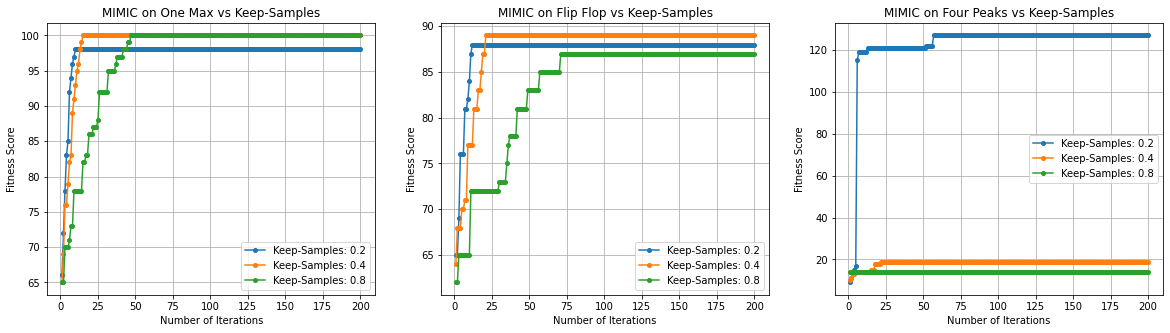

In [59]:
# Tuning MIMIC - Proportion of samples to keep
   
_, axes = plt.subplots(1, 3, figsize=(20, 5))
ax = 0
for ff_k, ff_v in fitness_functions.items():
    axes[ax].set_title(f"MIMIC on {ff_k} vs Keep-Samples")
    best_param = None
    best_fitness = float("-inf")
    for keep_pct in [0.2, 0.4, 0.8]:
        # Define discrete-state optimization problem
        opt_problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=ff_v, maximize=True)
        # Find optimum using MIMIC
        _, mimic_bf, mimic_fc = mimic(opt_problem, MAX_ATTEMPTS, MAX_ITERATIONS, keep_pct=keep_pct)

        if mimic_bf > best_fitness:
            # print(f"{ff_k}, found better bf: {mimic_bf} at {keep_pct}")
            best_param = keep_pct
            best_fitness = mimic_bf

        axes[ax].plot(range(1, MAX_ITERATIONS+1), mimic_fc, "o-", label=f"Keep-Samples: {keep_pct}", markersize=4)
        axes[ax].set_xlabel("Number of Iterations")
        axes[ax].set_ylabel("Fitness Score")
        axes[ax].legend() # loc="best" by default
    axes[ax].grid()
    ax += 1

    print(f"MIMIC - Best parameter value for {ff_k} => Percentage of samples to keep: {best_param}")
plt.savefig(cur_dir + "/plots/HT_MIMIC_keep_pct")

Time (s) - RHC|One Max : 0.9457671642303467
Time (s) - RHC|Flip Flop : 25.4231538772583
Time (s) - RHC|Four Peaks : 0.9497296810150146
Time (s) - SA|One Max : 0.006845235824584961
Time (s) - SA|Flip Flop : 0.07406377792358398
Time (s) - SA|Four Peaks : 0.005529165267944336
Time (s) - GA|One Max : 1.6677889823913574
Time (s) - GA|Flip Flop : 47.83779287338257
Time (s) - GA|Four Peaks : 4.976196050643921
Time (s) - MIMIC|One Max : 949.3546853065491
Time (s) - MIMIC|Flip Flop : 933.1438641548157
Time (s) - MIMIC|Four Peaks : 878.2536308765411


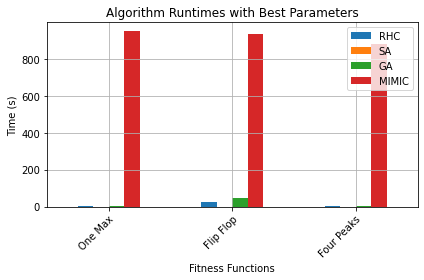

In [65]:

# RHC with best parameters
rhc_best_params = [200, 500, 300]
# _, axes = plt.subplots(2, 2, figsize=(15, 5))
ff_idx = 0
rhc_durations = []
for ff_k, ff_v in fitness_functions.items():
    opt_problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=ff_v, maximize=True)
    start_time = time.time()
    rhc(opt_problem, MAX_ATTEMPTS, MAX_ITERATIONS, rhc_best_params[ff_idx])
    end_time = time.time()
    ff_idx += 1
    
    rhc_duration = end_time - start_time
    rhc_durations.append(rhc_duration)
    print(f"Time (s) - RHC|{ff_k} : {rhc_duration}")

# SA
sa_best_params = [schedules[0], schedules[1], schedules[0]]
ff_idx = 0
sa_durations = []
for ff_k, ff_v in fitness_functions.items():
    opt_problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=ff_v, maximize=True)
    start_time = time.time()
    sa(opt_problem, MAX_ATTEMPTS, MAX_ITERATIONS, sa_best_params[ff_idx][1])
    end_time = time.time()
    ff_idx += 1
    
    sa_duration = end_time - start_time
    sa_durations.append(sa_duration)
    print(f"Time (s) - SA|{ff_k} : {sa_duration}")

# GA
ga_best_params = [(100, 0.1), (750, 0.1), (250, 0.25)]
ff_idx = 0
ga_durations = []
for ff_k, ff_v in fitness_functions.items():
    opt_problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=ff_v, maximize=True)
    start_time = time.time()
    ga(opt_problem, MAX_ATTEMPTS, MAX_ITERATIONS, pop_size=ga_best_params[ff_idx][0], mutation_prob=ga_best_params[ff_idx][1])
    end_time = time.time()
    ff_idx += 1
    
    ga_duration = end_time - start_time
    ga_durations.append(ga_duration)
    print(f"Time (s) - GA|{ff_k} : {ga_duration}")

# MIMIC
mimic_best_params = [(400, 0.4), (400, 0.4), (200, 0.2)]
ff_idx = 0
mimic_durations = []
for ff_k, ff_v in fitness_functions.items():
    opt_problem = mlrose_hiive.DiscreteOpt(length=100, fitness_fn=ff_v, maximize=True)
    start_time = time.time()
    mimic(opt_problem, MAX_ATTEMPTS, MAX_ITERATIONS, pop_size=mimic_best_params[ff_idx][0], keep_pct=mimic_best_params[ff_idx][1])
    end_time = time.time()
    ff_idx += 1
    
    mimic_duration = end_time - start_time
    mimic_durations.append(mimic_duration)
    print(f"Time (s) - MIMIC|{ff_k} : {mimic_duration}")



d = {"Name": fitness_functions.keys(),
    "RHC": rhc_durations, "SA": sa_durations, "GA": ga_durations, "MIMIC": mimic_durations}
df_new = pd.DataFrame(d)
ax = df_new.set_index('Name').plot(kind="bar", align="center", width=0.5)
plt.title("Algorithm Runtimes with Best Parameters")
plt.xlabel("Fitness Functions")
plt.ylabel("Time (s)")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.legend(loc="upper right")
plt.tight_layout()
plt.grid()
plt.savefig(cur_dir + "/plots/all_runtimes")

